<a href="https://colab.research.google.com/github/SEOYUNJE/Lung-Image-Analysis/blob/main/torchxrayvision_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights')
od.download('https://www.kaggle.com/datasets/seoyunje/cxr-nih-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights


100%|██████████| 637M/637M [00:17<00:00, 37.6MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/cxr-nih-dataset


100%|██████████| 1.86G/1.86G [00:54<00:00, 36.9MB/s]


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8)

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=5)
    
- `Strong Augment`: CutMix(patch=2)
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: None
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [2]:
!pip install -q tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [3]:
import os
import gc
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


tensorflow version:  2.15.0
Using 1 GPUs


In [4]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [6]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [7]:
USE_CXR = True

In [8]:
if USE_CXR:
    df = pd.read_csv('/content/cxr-nih-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', 'cxr-nih-dataset','*', '*'))}

    df['path'] = df['Image Index'].map(tmp)

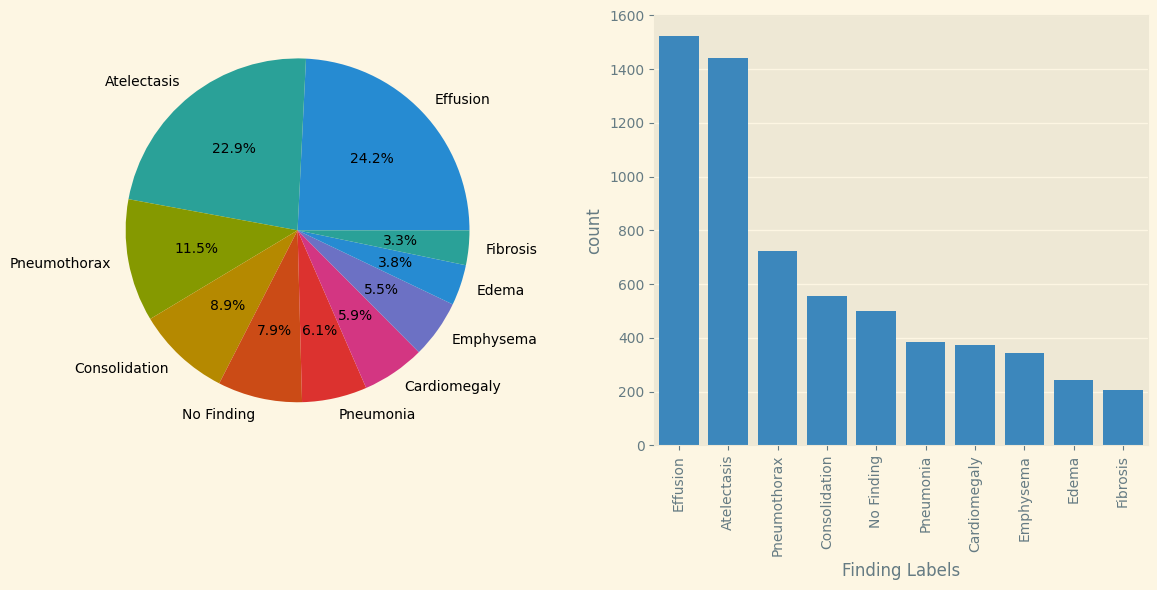

In [9]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Train & Test Split**

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [11]:
allowed_labels = ['No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
                  'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis']

for label in allowed_labels:
    df_test[label] = df_test['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')
    df_train[label] = df_train['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

TARGET = allowed_labels

In [12]:
TARGET

['No Finding',
 'Cardiomegaly',
 'Edema',
 'Atelectasis',
 'Pneumonia',
 'Effusion',
 'Pneumothorax',
 'Emphysema',
 'Consolidation',
 'Fibrosis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build MaskGenerator</b></div>

In [13]:
!pip install -q torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 62.3 MB/s eta 0:00:00


In [14]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

In [15]:
import torchxrayvision as xrv

In [16]:
import albumentations as albu

class MaskGenerator(Dataset):
    def __init__(self, data, preprocess=None):
        self.data = data
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        path = self.data.iloc[index]['path']
        img = Image.open(path).convert('L')
        img = img.resize((512,512), Image.Resampling.LANCZOS)
        img = np.array(img)
        img = self.clahe.apply(img)
        img = xrv.datasets.normalize(img, 255)
        img = np.expand_dims(img, axis=0)

        img = torch.from_numpy(img)

        return img


In [17]:
train_mask = MaskGenerator(df_train.sample(1_000, random_state=42).reset_index(drop=True))
train_loader = DataLoader( train_mask, batch_size=16, shuffle=False, num_workers=2, drop_last=False, )

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
%%time

seg_model = xrv.baseline_models.chestx_det.PSPNet()
seg_model.to(device).eval()

all_mask = []
with torch.no_grad():
    for batch in tqdm(train_loader):

        batch = batch.to(device)
        oof = seg_model(batch).cpu().numpy()

        all_mask.append(oof)

del seg_model
gc.collect()

all_mask = np.concatenate(all_mask)

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/pspnet_chestxray_best_model_4.pth -O /root/.torchxrayvision/models_data/pspnet_chestxray_best_model_4.pth`
[██████████████████████████████████████████████████]


100%|██████████| 63/63 [02:10<00:00,  2.07s/it]


CPU times: user 2min 6s, sys: 12.4 s, total: 2min 19s
Wall time: 2min 26s


In [20]:
all_mask = 1 / (1 + np.exp(-all_mask))  # sigmoid
all_mask[all_mask < 0.5] = 0
all_mask[all_mask > 0.5] = 1

In [21]:
all_mask = (all_mask * 255).astype('uint8').squeeze()

error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'


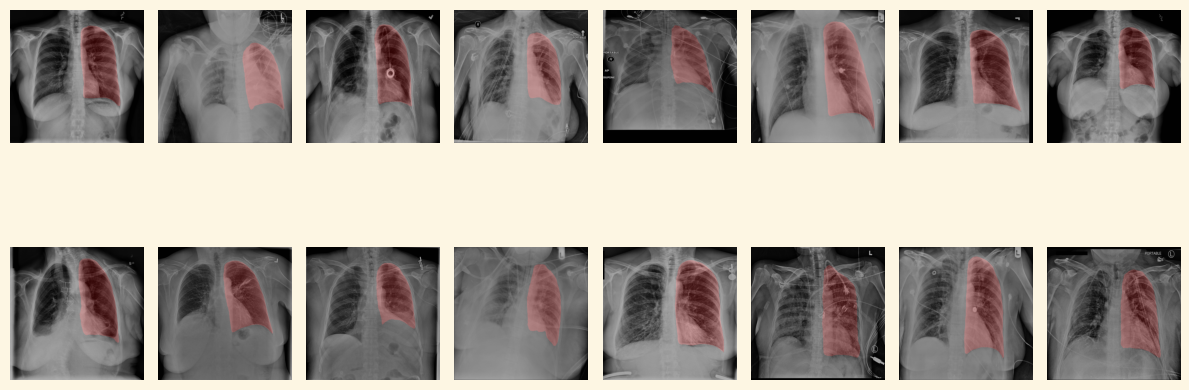

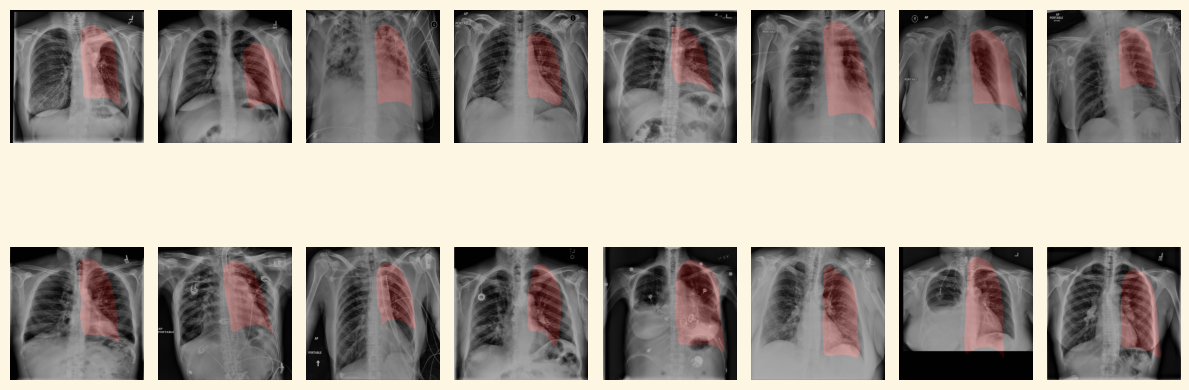

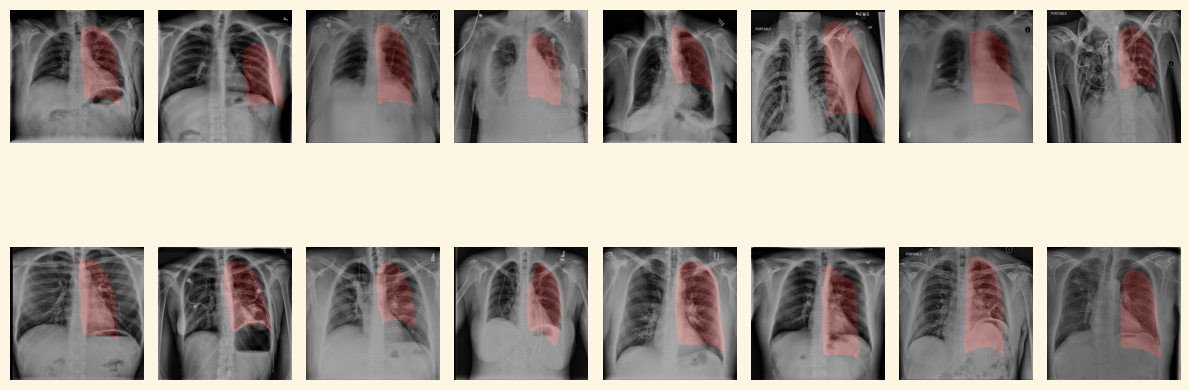

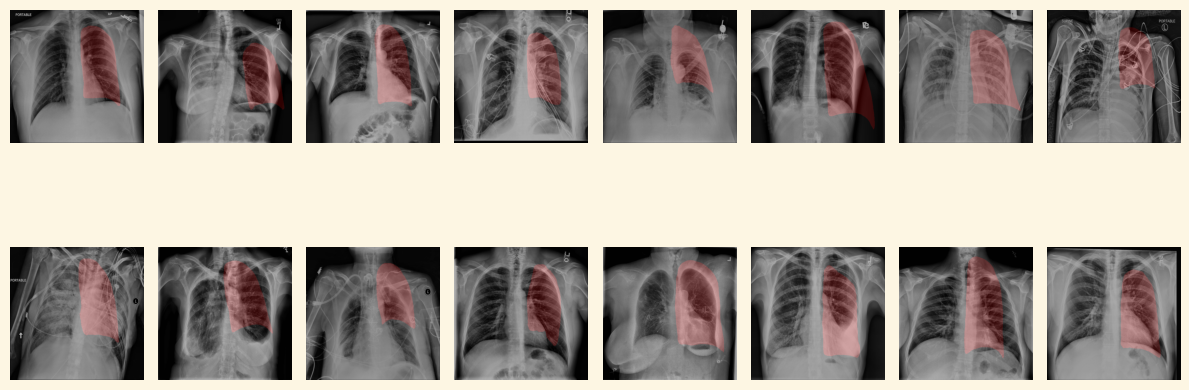

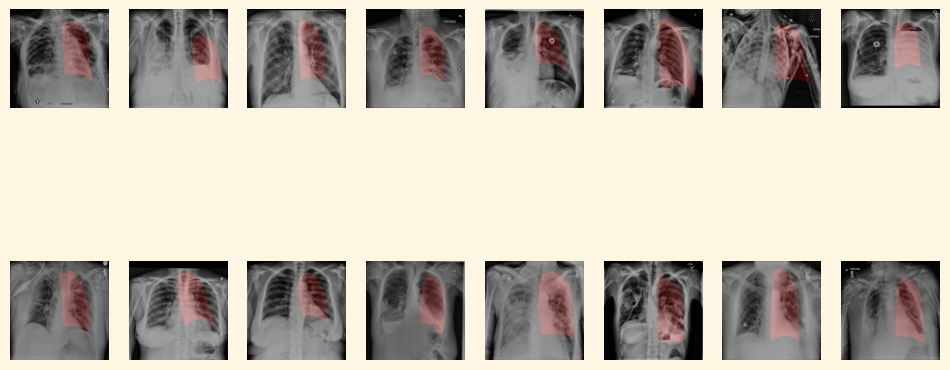

In [49]:
BATCH_IDX = 4



for batch_idx, X in enumerate(train_loader):
    plt.figure(figsize=(12,6))
    for i in range(16):
        plt.subplot(2,8, i+1)
        img = X[i,].numpy().squeeze()
        img = (img + 1024) / 2048.0
        img = (img*255).astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        tmp = all_mask[i][4]
        mask = cv2.cvtColor(all_mask[i][4], cv2.COLOR_GRAY2RGB)

        mask[tmp > 0, 0] = 150
        mask[tmp > 0, 1] = 0
        mask[tmp > 0, 2] = 0


        img = cv2.addWeighted(img, 0.7, mask, 0.3, 0)

        plt.imshow(img)
        plt.axis('off')

    if BATCH_IDX == batch_idx: break
    plt.tight_layout()
    plt.show()